### Import Library

In [1]:
import pandas as pd
import numpy as np
import os
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt
import math

from linearmodels import PanelOLS
from linearmodels import PooledOLS
from linearmodels import RandomEffects
from linearmodels.panel.results import compare
from linearmodels.iv import IV2SLS

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_white, het_breuschpagan, acorr_breusch_godfrey
from statsmodels.stats.stattools import durbin_watson

import numpy.linalg as la
from scipy import stats
from scipy.stats import boxcox
from scipy.stats import kstest
from scipy.stats import chi2


pd.set_option('display.max_rows',None, 'display.max_columns',None,'display.max_colwidth', None)
pd.options.display.float_format = '{:.10f}'.format

### Read Data

In [2]:
ResInv = pd.read_csv('FinalVariables.csv')
ResInv.columns

Index(['Unnamed: 0_x', 'Unnamed: 0.1_x', 'Unnamed: 0.1.1_x',
       'Unnamed: 0.1.1.1_x', 'Unnamed: 0.1.1.1.1_x', 'Unnamed: 0.1.1.1.1.1_x',
       'Unnamed: 0.1.1.1.1.1.1_x', 'Unnamed: 0.1.1.1.1.1.1.1_x',
       'Unnamed: 0.1.1.1.1.1.1.1.1_x', 'Unnamed: 0.1.1.1.1.1.1.1.1.1_x',
       ...
       'ResInv2011', 'ResInv2012', 'ResInv2013', 'ResInv2014', 'ResInv2015',
       'ResInv2016', 'ResInv2017', 'ResInv2018', 'ResInv2019', 'ResInv2020'],
      dtype='object', length=377)

In [3]:
Unnamed = []

for row in ResInv:
    if row.startswith('Unnamed'):
        Unnamed.append(row)
    
ResInv.drop(Unnamed, axis = 1,inplace = True)

- **Calculate Residential Renovations Per Housing Unit**

In [4]:
#scale for housing units
Years = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020]

for year in Years:
#     print(year)
    ResInv['ResRenoPerHousingUnits'+str(year)] = (ResInv['ResReno'+str(year)]/ResInv['HousingUnits'+str(year)])*100

### Education Interpolation 
- **US Census Bureau doesn't have Education attainment for the years 2010 and 2011 so use 2012 figures**

In [5]:
ResInv['PercentAdultsWithAtLeastBachelors2010'] = ResInv['PercentAdultsWithAtLeastBachelors2012']
ResInv['PercentAdultsWithAtLeastBachelors2011'] = ResInv['PercentAdultsWithAtLeastBachelors2012']

### Compute Renovations

- **Compute Sum of Investments 5 year range**

- Renovations 

In [6]:
ResInv['Reno2010_2014'] = ResInv[['ResReno2010','ResReno2011','ResReno2012','ResReno2013','ResReno2014' ]].sum(axis = 1)
ResInv['Reno2015_2019'] = ResInv[['ResReno2015','ResReno2016','ResReno2017','ResReno2018','ResReno2019' ]].sum(axis = 1) 

In [7]:
ResInv['Reno10Years'] = ResInv[['ResReno2010','ResReno2011','ResReno2012','ResReno2013','ResReno2014',
                                 'ResReno2015','ResReno2016','ResReno2017','ResReno2018','ResReno2019']].sum(axis = 1)

- Difference in 5 year sums 2010 to 2014 minus 2015 to 2019

In [8]:
ResInv['Reno5yearDiff'] =  ResInv['Reno2015_2019'] - ResInv['Reno2010_2014']

- Renovations Per Housing Unit normalized for the 5 years

In [9]:
ResInv['RenoHU2010_2014'] = (ResInv[['ResReno2010','ResReno2011','ResReno2012','ResReno2013','ResReno2014' ]].sum(axis = 1)/
                            ResInv['HousingUnits2010'])

ResInv['RenoHU2015_2019'] = (ResInv[['ResReno2015','ResReno2016','ResReno2017','ResReno2018','ResReno2019' ]].sum(axis = 1)/
                            ResInv['HousingUnits2015']) 

- Difference for renovations per housing unit normalized for 5 years

In [10]:
ResInv['RenoPerHU5yearDiff'] = ResInv['RenoHU2015_2019'] - ResInv['RenoHU2010_2014']

- Average Change in Percent Ownership for 5 years

In [11]:
ResInv['Ownership2010_2014'] = ResInv[['PercentOwnerOccupied2010','PercentOwnerOccupied2011',
                                       'PercentOwnerOccupied2012','PercentOwnerOccupied2013',
                                       'PercentOwnerOccupied2014' ]].mean(axis = 1)

ResInv['Ownership2015_2019'] = ResInv[['PercentOwnerOccupied2015','PercentOwnerOccupied2016',
                                       'PercentOwnerOccupied2017','PercentOwnerOccupied2018',
                                       'PercentOwnerOccupied2019' ]].mean(axis = 1)

In [12]:
ResInv['Ownership'] = ResInv['Ownership2015_2019'] - ResInv['Ownership2010_2014']

In [13]:
ResInv['OwnershipChange'] = ResInv['PercentOwnerOccupied2019'] - ResInv['PercentOwnerOccupied2010']

- Buildings 30 years and over

In [14]:
ResInv['Bld30Yrs2010_2014'] = ResInv[['Percent30Years2010','Percent30Years2011',
                                       'Percent30Years2012','Percent30Years2013',
                                       'Percent30Years2014' ]].mean(axis = 1)

ResInv['Bld30Yrs2015_2019'] = ResInv[['Percent30Years2015','Percent30Years2016',
                                       'Percent30Years2017','Percent30Years2018',
                                       'Percent30Years2019' ]].mean(axis = 1)

In [15]:
ResInv['Bld30yrs'] = ResInv['Bld30Yrs2015_2019'] - ResInv['Bld30Yrs2010_2014'] 

In [16]:
ResInv['Bld30yrsChange'] = ResInv['Percent30Years2019'] - ResInv['Percent30Years2010']

- Median Household Income

In [17]:
ResInv['Inc2010_2014'] = ResInv[['MHIncome2010','MHIncome2011','MHIncome2012','MHIncome2013','MHIncome2014' ]].mean(axis = 1)

ResInv['Inc2015_2019'] = ResInv[['MHIncome2015','MHIncome2016','MHIncome2017','MHIncome2018','MHIncome2019' ]].mean(axis = 1)

In [18]:
ResInv['Income'] =  ResInv['Inc2015_2019'] - ResInv['Inc2010_2014'] 

In [19]:
ResInv['IncomeChange'] = ResInv['MHIncome2019'] - ResInv['MHIncome2010']

- Race

- White

In [20]:
ResInv['White2010_2014'] = ResInv[['PercentWhite2010','PercentWhite2011','PercentWhite2012',
                                   'PercentWhite2013','PercentWhite2014' ]].mean(axis = 1)

ResInv['White2015_2019'] = ResInv[['PercentWhite2015','PercentWhite2016','PercentWhite2017',
                                   'PercentWhite2018','PercentWhite2019' ]].mean(axis = 1)

In [21]:
ResInv['White'] = ResInv['White2015_2019'] - ResInv['White2010_2014']

In [22]:
ResInv['WhiteChange'] = ResInv['PercentWhite2019'] - ResInv['PercentWhite2010']

- Black

In [23]:
ResInv['Black2010_2014'] = ResInv[['PercentBlack2010','PercentBlack2011','PercentBlack2012',
                                   'PercentBlack2013','PercentBlack2014' ]].mean(axis = 1)

ResInv['Black2015_2019'] = ResInv[['PercentBlack2015','PercentBlack2016','PercentBlack2017',
                                  'PercentBlack2018','PercentBlack2019']].mean(axis = 1)
     

In [24]:
ResInv['Black'] = ResInv['Black2015_2019'] -ResInv['Black2010_2014']

In [25]:
ResInv['BlackChange'] = ResInv['PercentBlack2019'] -ResInv['PercentBlack2010']

- Hispanic

In [26]:
ResInv['Hispanic2010_2014'] = ResInv[['PercentHispanic2010','PercentHispanic2011','PercentHispanic2012',
                                   'PercentHispanic2013','PercentHispanic2014' ]].mean(axis = 1)

ResInv['Hispanic2015_2019'] = ResInv[['PercentHispanic2015','PercentHispanic2016','PercentHispanic2017',
                                  'PercentHispanic2018','PercentHispanic2019']].mean(axis = 1)
     

In [27]:
ResInv['Hispanic'] = ResInv['Hispanic2015_2019'] - ResInv['Hispanic2010_2014']

In [28]:
ResInv['HispanicChange'] = ResInv['PercentHispanic2019'] -ResInv['PercentHispanic2010']

 - Education Attainment

In [29]:
ResInv['Education2010_2014'] = ResInv[['PercentAdultsWithAtLeastBachelors2010','PercentAdultsWithAtLeastBachelors2011',
                                       'PercentAdultsWithAtLeastBachelors2012',
                                   'PercentAdultsWithAtLeastBachelors2013',
                                       'PercentAdultsWithAtLeastBachelors2014' ]].mean(axis = 1)

ResInv['Education2015_2019'] = ResInv[['PercentAdultsWithAtLeastBachelors2015','PercentAdultsWithAtLeastBachelors2016',
                                   'PercentAdultsWithAtLeastBachelors2017',
                                  'PercentAdultsWithAtLeastBachelors2018',
                                   'PercentAdultsWithAtLeastBachelors2019']].mean(axis = 1)
     

In [30]:
ResInv['Education'] = ResInv['Education2015_2019'] - ResInv['Education2010_2014'] 

In [31]:
ResInv['EducationChange'] = ResInv['PercentAdultsWithAtLeastBachelors2019'] - ResInv['PercentAdultsWithAtLeastBachelors2010'] 

- Housing Units

In [32]:
ResInv['HousingUnits2010_2014'] = ResInv[['HousingUnits2010','HousingUnits2011',
                                       'HousingUnits2012',
                                   'HousingUnits2013',
                                       'HousingUnits2014' ]].mean(axis = 1)

ResInv['HousingUnits2015_2019'] = ResInv[['HousingUnits2015','HousingUnits2016',
                                   'HousingUnits2017',
                                  'HousingUnits2018',
                                   'HousingUnits2019']].mean(axis = 1)
     

In [33]:
ResInv['Housing'] = ResInv['HousingUnits2015_2019'] - ResInv['HousingUnits2010_2014'] 

In [34]:
ResInv['HousingChange'] = ResInv['HousingUnits2019'] - ResInv['HousingUnits2010'] 

 - Sales Price

In [35]:
ResInv['SalesPrice2010_2014'] = ResInv[['Price2010','Price2011','Price2012','Price2013','Price2014' ]].mean(axis = 1)

ResInv['SalesPrice2015_2019'] = ResInv[['Price2015','Price2016','Price2017','Price2018','Price2019' ]].mean(axis = 1)

In [36]:
ResInv['MedianSalesAverageChange'] = ResInv['SalesPrice2015_2019'] - ResInv['SalesPrice2010_2014'] 

In [37]:
ResInv['SalesChange'] = ResInv['Price2019'] - ResInv['Price2010'] 

- Net Building Value

In [38]:
ResInv['NetBldValue2010_2014'] = ResInv[['NetBldgVal2010','NetBldgVal2011','NetBldgVal2012',
                                'NetBldgVal2013','NetBldgVal2014' ]].mean(axis = 1)

ResInv['NetBldValue2015_2019'] = ResInv[['NetBldgVal2015','NetBldgVal2016','NetBldgVal2017',
                                'NetBldgVal2018','NetBldgVal2019' ]].mean(axis = 1)

In [39]:
ResInv['NetBuildingValue'] = ResInv['NetBldValue2015_2019'] - ResInv['NetBldValue2010_2014'] 

In [40]:
ResInv['NetBldValueChange'] = ResInv['NetBldgVal2019'] - ResInv['NetBldgVal2010'] 

- Average Age

In [41]:
ResInv['AverageAge2010_2014'] = ResInv[['AverageYearBuilt2010','AverageYearBuilt2011','AverageYearBuilt2012',
                                'AverageYearBuilt2013','AverageYearBuilt2014' ]].mean(axis = 1)

ResInv['AverageAge2015_2019'] = ResInv[['AverageYearBuilt2015','AverageYearBuilt2016','AverageYearBuilt2017',
                                'AverageYearBuilt2018','AverageYearBuilt2019' ]].mean(axis = 1)

In [42]:
ResInv['AverageAgeChange'] = ResInv['AverageYearBuilt2019'] - ResInv['AverageYearBuilt2010'] 

- Single Family Units

In [43]:
ResInv['SingleFamily2010_2014'] = ResInv[['SFUnits2010','SFUnits2011','SFUnits2012','SFUnits2013','SFUnits2014']].mean(axis=1)
ResInv['SingleFamily2015_2019'] = ResInv[['SFUnits2015','SFUnits2016','SFUnits2017','SFUnits2018','SFUnits2019']].mean(axis=1)


In [44]:
ResInv['SingleFamAverage'] = ResInv['SingleFamily2015_2019'] - ResInv['SingleFamily2010_2014'] 

In [45]:
ResInv['SFChange'] = ResInv['SFUnits2019'] - ResInv['SFUnits2010']

In [46]:
# ResInv[col].agg(['mean', 'std','max','min'])

In [77]:
### Full Model

IndependentVariables = ['White','PercentWhite2010','PercentAdultsWithAtLeastBachelors2010',
                        'Education','Bld30yrs','Percent30Years2010','AverageAge2010_2014','SingleFamAverage','SFChange',
                        'NetBldValue2015_2019','SalesPrice2010_2014','Price2010','NetBldgVal2010','AverageYearBuilt2010',
                        'Ownership','PercentOwnerOccupied2010','Income','MHIncome2010','Housing','HousingUnits2010' ]

In [48]:
### Full Model

# IndependentVariables = ['White','PercentWhite2010','PercentAdultsWithAtLeastBachelors2010',
#                         'Education','Bld30yrs','Percent30Years2010',
#                         'Ownership','PercentOwnerOccupied2010','Income','MHIncome2010','Housing','HousingUnits2010' ]

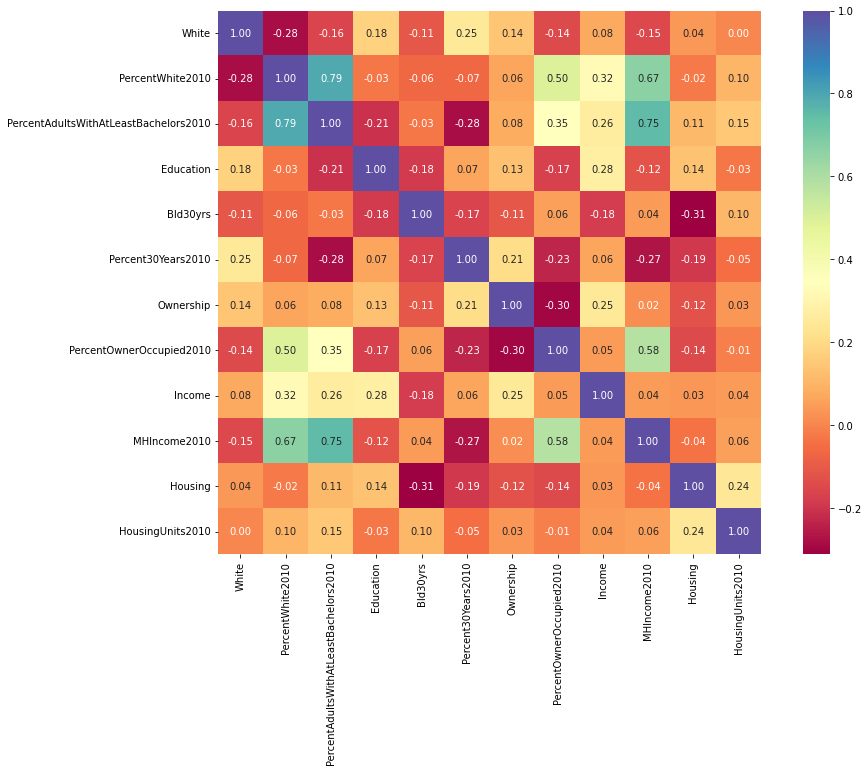

In [49]:
corrmat = ResInv[IndependentVariables].corr()
f, ax = plt.subplots(figsize=(15, 10))
sns.heatmap(corrmat, vmax=1, square=True,fmt= '.2f',annot_kws={'size': 10}, 
            annot= True, cmap="Spectral")
plt.show();

## Regresssion 

In [50]:
# Exogeneous = sm.add_constant(ResInv[IndependentVariables])
# Lasso = sm.OLS(ResInv.Reno5yearDiff, Exogeneous).fit_regularized(alpha=1.0, L1_wt=1.0)
# print(Lasso.params)

In [51]:
VIF = pd.DataFrame(ResInv[IndependentVariables])
VIF.replace([np.inf, -np.inf,np.nan], 0, inplace=True)

In [52]:
ResInv.replace([np.inf, -np.inf,np.nan], 0, inplace=True)

In [53]:
def calc_vif(X):
    vif = pd.DataFrame()
    vif['Variable'] = X.columns
    vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)


In [54]:
calc_vif(VIF).sort_values(by=['VIF'],ascending=False)

,Variable,VIF
2,PercentAdultsWithAtLeastBachelors2010,19.0782735492
9,MHIncome2010,16.1302293283
1,PercentWhite2010,13.7720784043
7,PercentOwnerOccupied2010,10.2038002111
11,HousingUnits2010,3.9458331945
5,Percent30Years2010,3.2755684435
10,Housing,1.9036596251
8,Income,1.8748509932
6,Ownership,1.7497287496
4,Bld30yrs,1.7368890999


In [55]:
ResInv.replace([np.inf, -np.inf,np.nan], 0, inplace=True)

# ResInv = ResInv.dropna()

ResInv.shape

(386, 389)

- **Difference in 5 year sums *2010 to 2014* minus *2015 to 2019***

In [57]:
## Full Model

# IndependentVariables = ['White','PercentWhite2010','PercentAdultsWithAtLeastBachelors2010',
#                         'Education','Bld30yrs','Percent30Years2010',
#                         'Ownership','PercentOwnerOccupied2010','Income','MHIncome2010','Housing',
#                         'HousingUnits2010' ]

In [58]:
# IndependentVariables = ['White','PercentWhite2010','Bld30yrs','Percent30Years2010',
#                        'Ownership','PercentOwnerOccupied2010','Housing','HousingUnits2010']

In [59]:
IndependentVariables = ['White','PercentWhite2010','PercentAdultsWithAtLeastBachelors2010','SingleFamAverage','SFChange',
                        'Education','Bld30yrs','Percent30Years2010','AverageAge2010_2014','SFUnits2010',
                        'NetBldValue2015_2019','SalesPrice2010_2014','Price2010','NetBldgVal2010','AverageYearBuilt2010',
                        'Ownership','PercentOwnerOccupied2010','Income','MHIncome2010','Housing','HousingUnits2010' ]

In [56]:
## Full Model

# IndependentVariables = ['White2012_2017','Per30Years2012_2017','PercentWhite2015','Percent30Years2015',
#                        'Inc2012_2017','MHIncome2015','Ownership2012_2017','PercentOwnerOccupied2015','HousingUnits2015' ]

In [60]:
IndependentVariables = ['White','PercentWhite2010','PercentAdultsWithAtLeastBachelors2010',
                        'Education','Bld30yrs','Percent30Years2010',
                        'Ownership','PercentOwnerOccupied2010','Income','MHIncome2010','Housing','HousingUnits2010' ]

In [61]:
Exogeneous = sm.add_constant(ResInv[IndependentVariables])

PerAgg = sm.OLS(ResInv.Reno5yearDiff, Exogeneous)
PerAggOLS = PerAgg.fit()
print(PerAggOLS.summary())


                            OLS Regression Results                            
Dep. Variable:            Reno10Years   R-squared:                       0.645
Model:                            OLS   Adj. R-squared:                  0.634
Method:                 Least Squares   F-statistic:                     56.58
Date:                Wed, 20 Sep 2023   Prob (F-statistic):           2.43e-76
Time:                        13:36:37   Log-Likelihood:                -2124.9
No. Observations:                 386   AIC:                             4276.
Df Residuals:                     373   BIC:                             4327.
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [62]:
# residuals = PerAggOLS.resid
# residualdf = pd.DataFrame({
#     'NPA': ResInv['NPA'],
#     'residuals': residuals})
# residualdf.to_csv('Reno5yearDiff.csv',index = False)

In [76]:
p_values = PerAggOLS.pvalues

alpha = 0.05

stars = ['*' if p < alpha else '' for p in p_values]

summary_table = pd.DataFrame({
    'Coefficient': PerAggOLS.params,
    'p-value': p_values,
    'Significance': stars
})

pd.DataFrame(summary_table)

,Coefficient,p-value,Significance
const,5518.6522141516,0.0000000000,*
OwnershipChange,0.3604647956,0.1764096911,
Bld30yrsChange,0.6062183353,0.5332104842,
IncomeChange,0.0005617191,0.0032383491,*
MHIncome2010,0.0007938797,0.0001952472,*
WhiteChange,-0.0075880514,0.9775938094,
PercentWhite2010,0.1182839474,0.5860730986,
PercentAdultsWithAtLeastBachelors2010,0.0311534211,0.9208504841,
EducationChange,0.0456134505,0.8871329581,
HousingChange,0.0126232466,0.1627789749,


- **Ten year sum on average 5 year difference** 

In [64]:
IndependentVariables = ['White','PercentWhite2010','PercentAdultsWithAtLeastBachelors2010',
                        'Education','Bld30yrs','Percent30Years2010',
                        'NetBuildingValue','NetBldgVal2010','MedianSalesAverageChange','Price2010',
                        'Ownership','PercentOwnerOccupied2010','Income','MHIncome2010','Housing','HousingUnits2010' ]

In [65]:
Exogeneous = sm.add_constant(ResInv[IndependentVariables])

PerAgg = sm.OLS(ResInv.Reno10Years, Exogeneous)
PerAggOLS = PerAgg.fit()
print(PerAggOLS.summary())

                            OLS Regression Results                            
Dep. Variable:            Reno10Years   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     47.78
Date:                Wed, 20 Sep 2023   Prob (F-statistic):           1.30e-79
Time:                        13:36:38   Log-Likelihood:                -2108.4
No. Observations:                 386   AIC:                             4251.
Df Residuals:                     369   BIC:                             4318.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [66]:
p_values = PerAggOLS.pvalues

alpha = 0.05

stars = ['*' if p < alpha else '' for p in p_values]

summary_table = pd.DataFrame({
    'Coefficient': PerAggOLS.params,
    'p-value': p_values,
    'Significance': stars
})

pd.DataFrame(summary_table)

,Coefficient,p-value,Significance
const,-161.5110337076,0.0000000000,*
White,0.7576845508,0.0528534850,
PercentWhite2010,0.0676639229,0.7652147127,
PercentAdultsWithAtLeastBachelors2010,0.0844108358,0.8020137000,
Education,-0.3525471296,0.4863721706,
Bld30yrs,-1.5126345195,0.0606071281,
Percent30Years2010,0.6194551203,0.0000019781,*
NetBuildingValue,0.0000086424,0.8262304038,
NetBldgVal2010,0.0000163160,0.7334601131,
MedianSalesAverageChange,0.0006423267,0.0000000277,*


- **Difference in 5 year sums *2010 to 2014* minus *2015 to 2019 for Renovations Per Housing Unit***

In [67]:
## Full Model

# IndependentVariables = ['White2012_2017','Per30Years2012_2017','PercentWhite2015','Percent30Years2015',
#                        'Inc2012_2017','MHIncome2015','Ownership2012_2017','PercentOwnerOccupied2015' ]

In [68]:
# IndependentVariables = ['White','PercentWhite2010','PercentAdultsWithAtLeastBachelors2010',
#                         'Education','Bld30yrs','Percent30Years2010','AverageAge2010_2014',
#                         'NetBldValue2015_2019','SalesPrice2010_2014','Price2010','NetBldgVal2010','AverageYearBuilt2010',
#                         'Ownership','PercentOwnerOccupied2010','Income','MHIncome2010' ,'Housing','HousingUnits2010']

In [69]:
IndependentVariables = ['White','PercentWhite2010','PercentAdultsWithAtLeastBachelors2010',
                        'Education','Bld30yrs','Percent30Years2010',
                        'Ownership','PercentOwnerOccupied2010','Income','MHIncome2010']

In [70]:
Exogeneous = sm.add_constant(ResInv[IndependentVariables])

PerAgg = sm.OLS(ResInv.RenoPerHU5yearDiff, Exogeneous)
PerAggOLS = PerAgg.fit()
print(PerAggOLS.summary())

                            OLS Regression Results                            
Dep. Variable:     RenoPerHU5yearDiff   R-squared:                       0.238
Model:                            OLS   Adj. R-squared:                  0.217
Method:                 Least Squares   F-statistic:                     11.70
Date:                Wed, 20 Sep 2023   Prob (F-statistic):           1.45e-17
Time:                        13:36:38   Log-Likelihood:                 161.20
No. Observations:                 386   AIC:                            -300.4
Df Residuals:                     375   BIC:                            -256.9
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [71]:
# residuals = PerAggOLS.resid
# residualdf = pd.DataFrame({
#     'NPA': ResInv['NPA'],
#     'residuals': residuals})
# residualdf.to_csv('RenoPerHU5yearDiff.csv',index = False)

In [72]:
p_values = PerAggOLS.pvalues

alpha = 0.05

stars = ['*' if p < alpha else '' for p in p_values]

summary_table = pd.DataFrame({
    'Coefficient': PerAggOLS.params,
    'p-value': p_values,
    'Significance': stars
})

pd.DataFrame(summary_table)

,Coefficient,p-value,Significance
const,-0.0193415221,0.5842446708,
White,0.0000925714,0.9308703942,
PercentWhite2010,0.0006057494,0.3128383224,
PercentAdultsWithAtLeastBachelors2010,0.0000892268,0.9204431604,
Education,-0.0032498584,0.0183827606,*
Bld30yrs,0.0175039330,0.0000000000,*
Percent30Years2010,0.0004633587,0.1320662292,
Ownership,-0.0033949415,0.0033285791,*
PercentOwnerOccupied2010,-0.0002051254,0.6460284715,
Income,0.0000008379,0.2866318059,


- **Ten year sum on percentage change in the decade**

In [73]:
IndependentVariables = ['OwnershipChange','Bld30yrsChange','IncomeChange','MHIncome2010', 'WhiteChange',
                        'PercentWhite2010','PercentAdultsWithAtLeastBachelors2010',
                        'EducationChange','HousingChange','Percent30Years2010','SalesChange','Price2010',
                        'NetBldValueChange','AverageAgeChange','NetBldgVal2010','AverageYearBuilt2010',
                        'PercentOwnerOccupied2010','HousingUnits2010']

In [74]:
Exogeneous = sm.add_constant(ResInv[IndependentVariables])

PerAgg = sm.OLS(ResInv.Reno10Years, Exogeneous)
PerAggOLS = PerAgg.fit()
print(PerAggOLS.summary())

                            OLS Regression Results                            
Dep. Variable:            Reno10Years   R-squared:                       0.732
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     55.72
Date:                Wed, 20 Sep 2023   Prob (F-statistic):           3.48e-93
Time:                        13:36:39   Log-Likelihood:                -2070.8
No. Observations:                 386   AIC:                             4180.
Df Residuals:                     367   BIC:                             4255.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
                                            coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------

In [75]:
p_values = PerAggOLS.pvalues

alpha = 0.05

stars = ['*' if p < alpha else '' for p in p_values]

summary_table = pd.DataFrame({
    'Coefficient': PerAggOLS.params,
    'p-value': p_values,
    'Significance': stars
})

pd.DataFrame(summary_table)

,Coefficient,p-value,Significance
const,5518.6522141516,0.0000000000,*
OwnershipChange,0.3604647956,0.1764096911,
Bld30yrsChange,0.6062183353,0.5332104842,
IncomeChange,0.0005617191,0.0032383491,*
MHIncome2010,0.0007938797,0.0001952472,*
WhiteChange,-0.0075880514,0.9775938094,
PercentWhite2010,0.1182839474,0.5860730986,
PercentAdultsWithAtLeastBachelors2010,0.0311534211,0.9208504841,
EducationChange,0.0456134505,0.8871329581,
HousingChange,0.0126232466,0.1627789749,
